# Gaussian Model in Pytorch

## Import libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from library.GaussianRegression import GaussianRegression

# Set random seed for reproducibility
torch.manual_seed(123)

## Step 1: Generate synthetic data based on a linear model

In [2]:
# Step 1: Generate synthetic data based on a linear model
# y_i ~ N(X_i β, σ²)
n = 10000  # sample size
p = 5        # number of predictors (excluding intercept); change as needed

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: Choose random intercept and slopes (shape: (p+1, 1))
# Using standard normal draws (you can scale or shift as needed)
true_beta = torch.randn(p+1, 1)
true_sigma = 1.5  # standard deviation of the error term

# Generate response variable with noise (μ = Xβ, σ = true_sigma)
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)  # Add intercept column
mu = X_with_intercept @ true_beta  # μ = Xβ
epsilon = torch.randn(n, 1) * true_sigma  # ε ~ N(0, σ²)
y = mu + epsilon  # y = Xβ + ε

# Step 2: Instantiate model and optimizer

In [3]:
# Step 2: Instantiate model and optimizer using X to deduce input dimension
model = GaussianRegression(X)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Train the model

In [4]:
# Step 3: Train the model
num_epochs = 10000
losses = []

for epoch in range(num_epochs):
    # Compute negative log-likelihood
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

Epoch [1000/10000], NLL: 40212.0781
Epoch [2000/10000], NLL: 31923.8711
Epoch [3000/10000], NLL: 26627.7109
Epoch [4000/10000], NLL: 20110.2891
Epoch [5000/10000], NLL: 18313.5020
Epoch [6000/10000], NLL: 18301.2617
Epoch [7000/10000], NLL: 18301.2617
Epoch [8000/10000], NLL: 18301.2617
Epoch [9000/10000], NLL: 18301.2617
Epoch [10000/10000], NLL: 18301.2617


# Step 4: Extract learned parameters

In [5]:
# Step 4: Extract learned parameters
learned_beta = model.beta.data.flatten()
learned_sigma = model.sigma().item()

print(f'Learned parameters:')
print(f'β = {learned_beta.tolist()}')
print(f'σ = {learned_sigma:.4f}')
print(f'True parameters:')
print(f'β = {true_beta.flatten().tolist()}')
print(f'σ = {true_sigma:.4f}')

Learned parameters:
β = [-0.6161682605743408, -0.48885419964790344, -0.5355420112609863, 0.6022506952285767, -2.560500383377075, 0.18994207680225372]
σ = 1.5086
True parameters:
β = [-0.6942135095596313, -0.48340314626693726, -0.530332624912262, 0.6093006134033203, -2.5594072341918945, 0.18734775483608246]
σ = 1.5000


# Step 5: Plot results

Skipping plot since p > 1 (plotting only works for a single predictor).


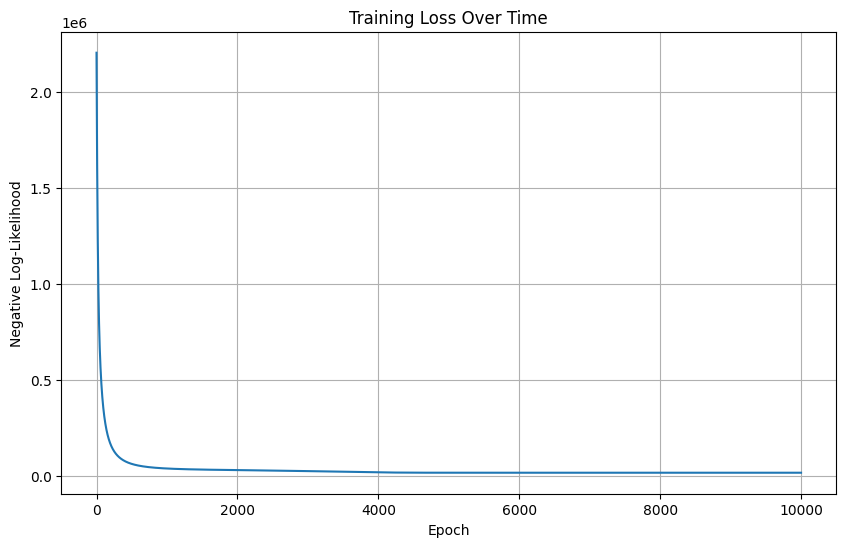

In [6]:
# Step 5: Plot results (only if p==1)
if p == 1:
    plt.figure(figsize=(10, 6))
    
    # Plot training data
    plt.scatter(X.numpy(), y.numpy(), label='Observations', s=1)
    
    # Plot the true regression line
    x_range = np.linspace(0, 10, 100).reshape(-1, 1)
    x_range_with_intercept = np.column_stack([np.ones(100), x_range])
    plt.plot(x_range, x_range_with_intercept @ true_beta.numpy(), 'r', 
             label=f'True: y = {true_beta[0].item():.2f} + {true_beta[1].item():.2f}x')
    
    # Plot the fitted regression line
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(x_range))
    plt.plot(x_range, y_pred.numpy(), 'g--', 
             label=f'Fitted: y = {learned_beta[0].item():.2f} + {learned_beta[1].item():.2f}x')
    
    # Plot confidence bands (μ ± 2σ)
    plt.fill_between(
        x_range.flatten(),
        (x_range_with_intercept @ learned_beta.unsqueeze(1).numpy() - 2 * learned_sigma).reshape(-1),
        (x_range_with_intercept @ learned_beta.unsqueeze(1).numpy() + 2 * learned_sigma).reshape(-1),
        alpha=0.2, color='g', label=f'95% Confidence Band (σ = {learned_sigma:.2f})'
    )
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Gaussian Regression with Fixed Effects (β) and Standard Deviation (σ)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping plot since p > 1 (plotting only works for a single predictor).")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

$$y \sim \mathcal{N}(\mu, \sigma^2) $$



$$ p(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi},\sigma}\exp\left(-\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2\right) $$

$$ -\log p(y \mid \mu, \sigma) = \frac{1}{2}\log(2\pi) + \log(\sigma) + \frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2 $$